# Adversarial Robustness of AI Text Detectors

**Research Question:** How fragile are AI text detectors to prompt engineering, and what linguistic features most influence detection?

This notebook analyzes the results of a systematic ablation study testing prompt engineering strategies against **ZeroGPT**. We generated 700 essays with Gemini 2.0 Flash under controlled prompt variations and measured detection rates.

**Detector:** ZeroGPT (`fakePercentage` score, 0-100)  
**Generator:** Gemini 2.0 Flash  
**Threshold:** An essay "passes" (reads as human) when `fakePercentage / 100 < 0.15`

## 1. Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path so we can import src modules
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sp_stats

from src import config
from src.analysis import (
    load_results,
    summarize_variants,
    summarize_by_topic,
    compare_to_baseline,
    compare_all_dimensions,
    rank_variants,
    temperature_summary,
    human_baseline_summary,
    export_summary_csv,
)

# Plot styling
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_colwidth", 60)
pd.set_option("display.float_format", "{:.4f}".format)

THRESHOLD = config.DETECTION_PASS_THRESHOLD
print(f"Detection pass threshold: completely_generated_prob < {THRESHOLD}")

Detection pass threshold: completely_generated_prob < 0.15


In [2]:
# Load raw results
df = load_results()
print(f"Loaded {len(df)} records")
print(f"Phases: {df['phase'].value_counts().to_dict()}")
print(f"Dimensions: {df['dimension'].unique().tolist()}")
df.head(3)

Loaded 700 records
Phases: {'ablation': 525, 'gen_params_sweep': 100, 'composite': 75}
Dimensions: ['gen_params', 'persona', 'structure', 'texture', 'content', 'meta', 'composite']


,timestamp,phase,dimension,variant_id,variant_label,topic,run_index,model,temperature,top_p,...,generation_latency_ms,generation_attempts,essay_text,detector,overall_ai_prob,burstiness,flagged_sentence_pct,passes_threshold,system_prompt,user_prompt
0,2026-02-08 05:30:10.324808+00:00,gen_params_sweep,gen_params,P6a,Baseline params,Write a 500-word essay about how social media affects te...,0,gemini-2.0-flash,0.7000,0.9000,...,4678,2,## The Double-Edged Scroll: Social Media's Impact on Tee...,zerogpt,1.0000,None,92.0000,False,,Write a 500-word essay about how social media affects te...
1,2026-02-08 05:30:31.829665+00:00,gen_params_sweep,gen_params,P6a,Baseline params,Write a 500-word essay about how social media affects te...,1,gemini-2.0-flash,0.7000,0.9000,...,5321,2,## The Double-Edged Sword: Social Media's Impact on Teen...,zerogpt,1.0000,None,96.2963,False,,Write a 500-word essay about how social media affects te...
2,2026-02-08 05:30:53.947082+00:00,gen_params_sweep,gen_params,P6a,Baseline params,Write a 500-word essay about how social media affects te...,2,gemini-2.0-flash,0.7000,0.9000,...,5023,2,## The Double-Edged Scroll: Social Media's Impact on Tee...,zerogpt,1.0000,None,96.5517,False,,Write a 500-word essay about how social media affects te...


## 2. Human Baselines

Detector scores on real student essays establish the false positive rate.
If the detector flags a significant fraction of human essays, then "passing" detection is less meaningful.

**Note:** Human baselines require `.txt` files in `data/human_baselines/`. If none are present, this section is skipped.

In [3]:
human_summary = human_baseline_summary(df)
if human_summary.empty:
    print("No human baseline data found. Add .txt files to data/human_baselines/ and run the experiment.")
else:
    display(human_summary)
    
    human_df = df[df["phase"] == "human_baseline"]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(range(len(human_df)), human_df["overall_ai_prob"], color="steelblue")
    ax.axhline(y=THRESHOLD, color="red", linestyle="--", label=f"Threshold ({THRESHOLD})")
    ax.set_xlabel("Essay")
    ax.set_ylabel("AI Probability")
    ax.set_title("GPTZero Scores on Human-Written Essays")
    ax.set_xticks(range(len(human_df)))
    ax.set_xticklabels(human_df["topic"].values, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()

No human baseline data found. Add .txt files to data/human_baselines/ and run the experiment.


## 3. Temperature Sweep (Tier 6)

Detection probability vs. generation temperature.
Higher temperature = more lexical randomness = potentially harder to detect.

**Hypothesis:** Temperature alone should reduce detection by increasing token-level entropy.  
**Spoiler:** It barely helps — only `temp=1.5` dips below 90%, and even then the effect is modest compared to prompt engineering.

,variant_label,temperature,n,mean_ai_prob,std_ai_prob,pass_rate
0,Baseline params,0.7000,25,0.9997,0.0016,0.0000
1,Moderate randomness,1.0000,25,1.0000,0.0000,0.0000
2,High randomness,1.3000,25,0.9996,0.0021,0.0000
3,Max randomness,1.5000,25,0.8192,0.2178,0.0000


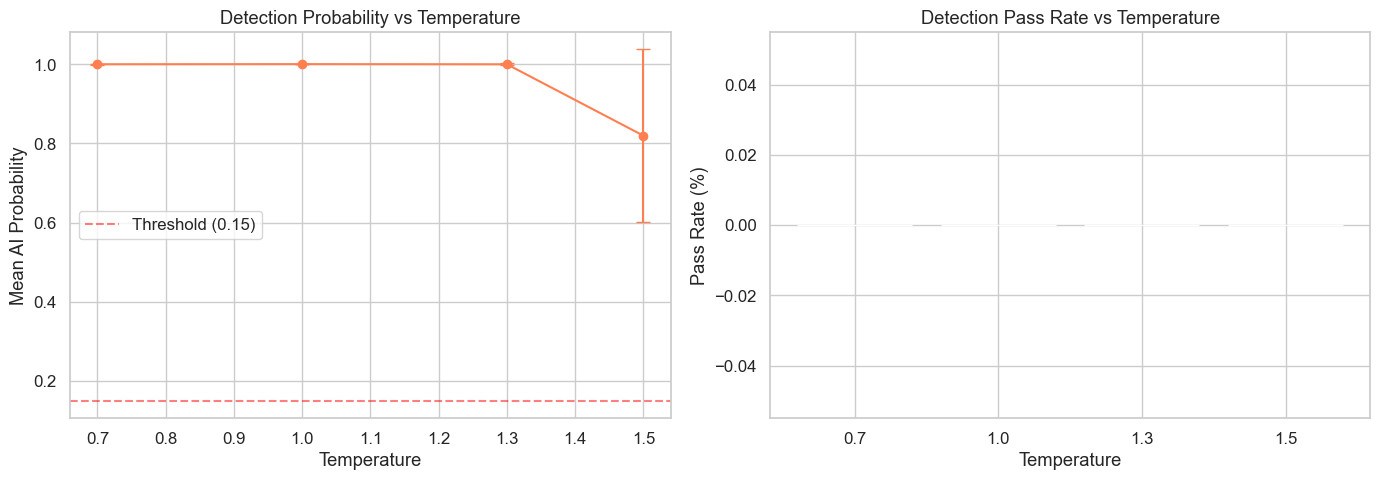

In [4]:
temp_df = temperature_summary(df)
if temp_df.empty:
    print("No gen_params_sweep data found. Run the temperature sweep first.")
else:
    display(temp_df[["variant_label", "temperature", "n", "mean_ai_prob", "std_ai_prob", "pass_rate"]])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: mean AI prob by temperature
    axes[0].errorbar(
        temp_df["temperature"], temp_df["mean_ai_prob"],
        yerr=temp_df["std_ai_prob"], fmt="o-", capsize=5, color="coral"
    )
    axes[0].axhline(y=THRESHOLD, color="red", linestyle="--", alpha=0.5, label=f"Threshold ({THRESHOLD})")
    axes[0].set_xlabel("Temperature")
    axes[0].set_ylabel("Mean AI Probability")
    axes[0].set_title("Detection Probability vs Temperature")
    axes[0].legend()
    
    # Right: pass rate by temperature
    axes[1].bar(temp_df["temperature"].astype(str), temp_df["pass_rate"] * 100, color="seagreen")
    axes[1].set_xlabel("Temperature")
    axes[1].set_ylabel("Pass Rate (%)")
    axes[1].set_title("Detection Pass Rate vs Temperature")
    
    plt.tight_layout()
    plt.show()

## 4. Ablation Results

For each prompt dimension (Tiers 1-5), we changed **one variable at a time** against the baseline to isolate its effect.
Box plots show the distribution of detection scores, and we report Cohen's d effect sizes and Mann-Whitney U p-values.

**Dimensions tested:**
- **Persona** (Tier 1): Voice and character framing
- **Structure** (Tier 2): Essay organization directives
- **Texture** (Tier 3): Sentence-level linguistic patterns
- **Content** (Tier 4): Specificity and source references
- **Meta** (Tier 5): Meta-instructions about writing context

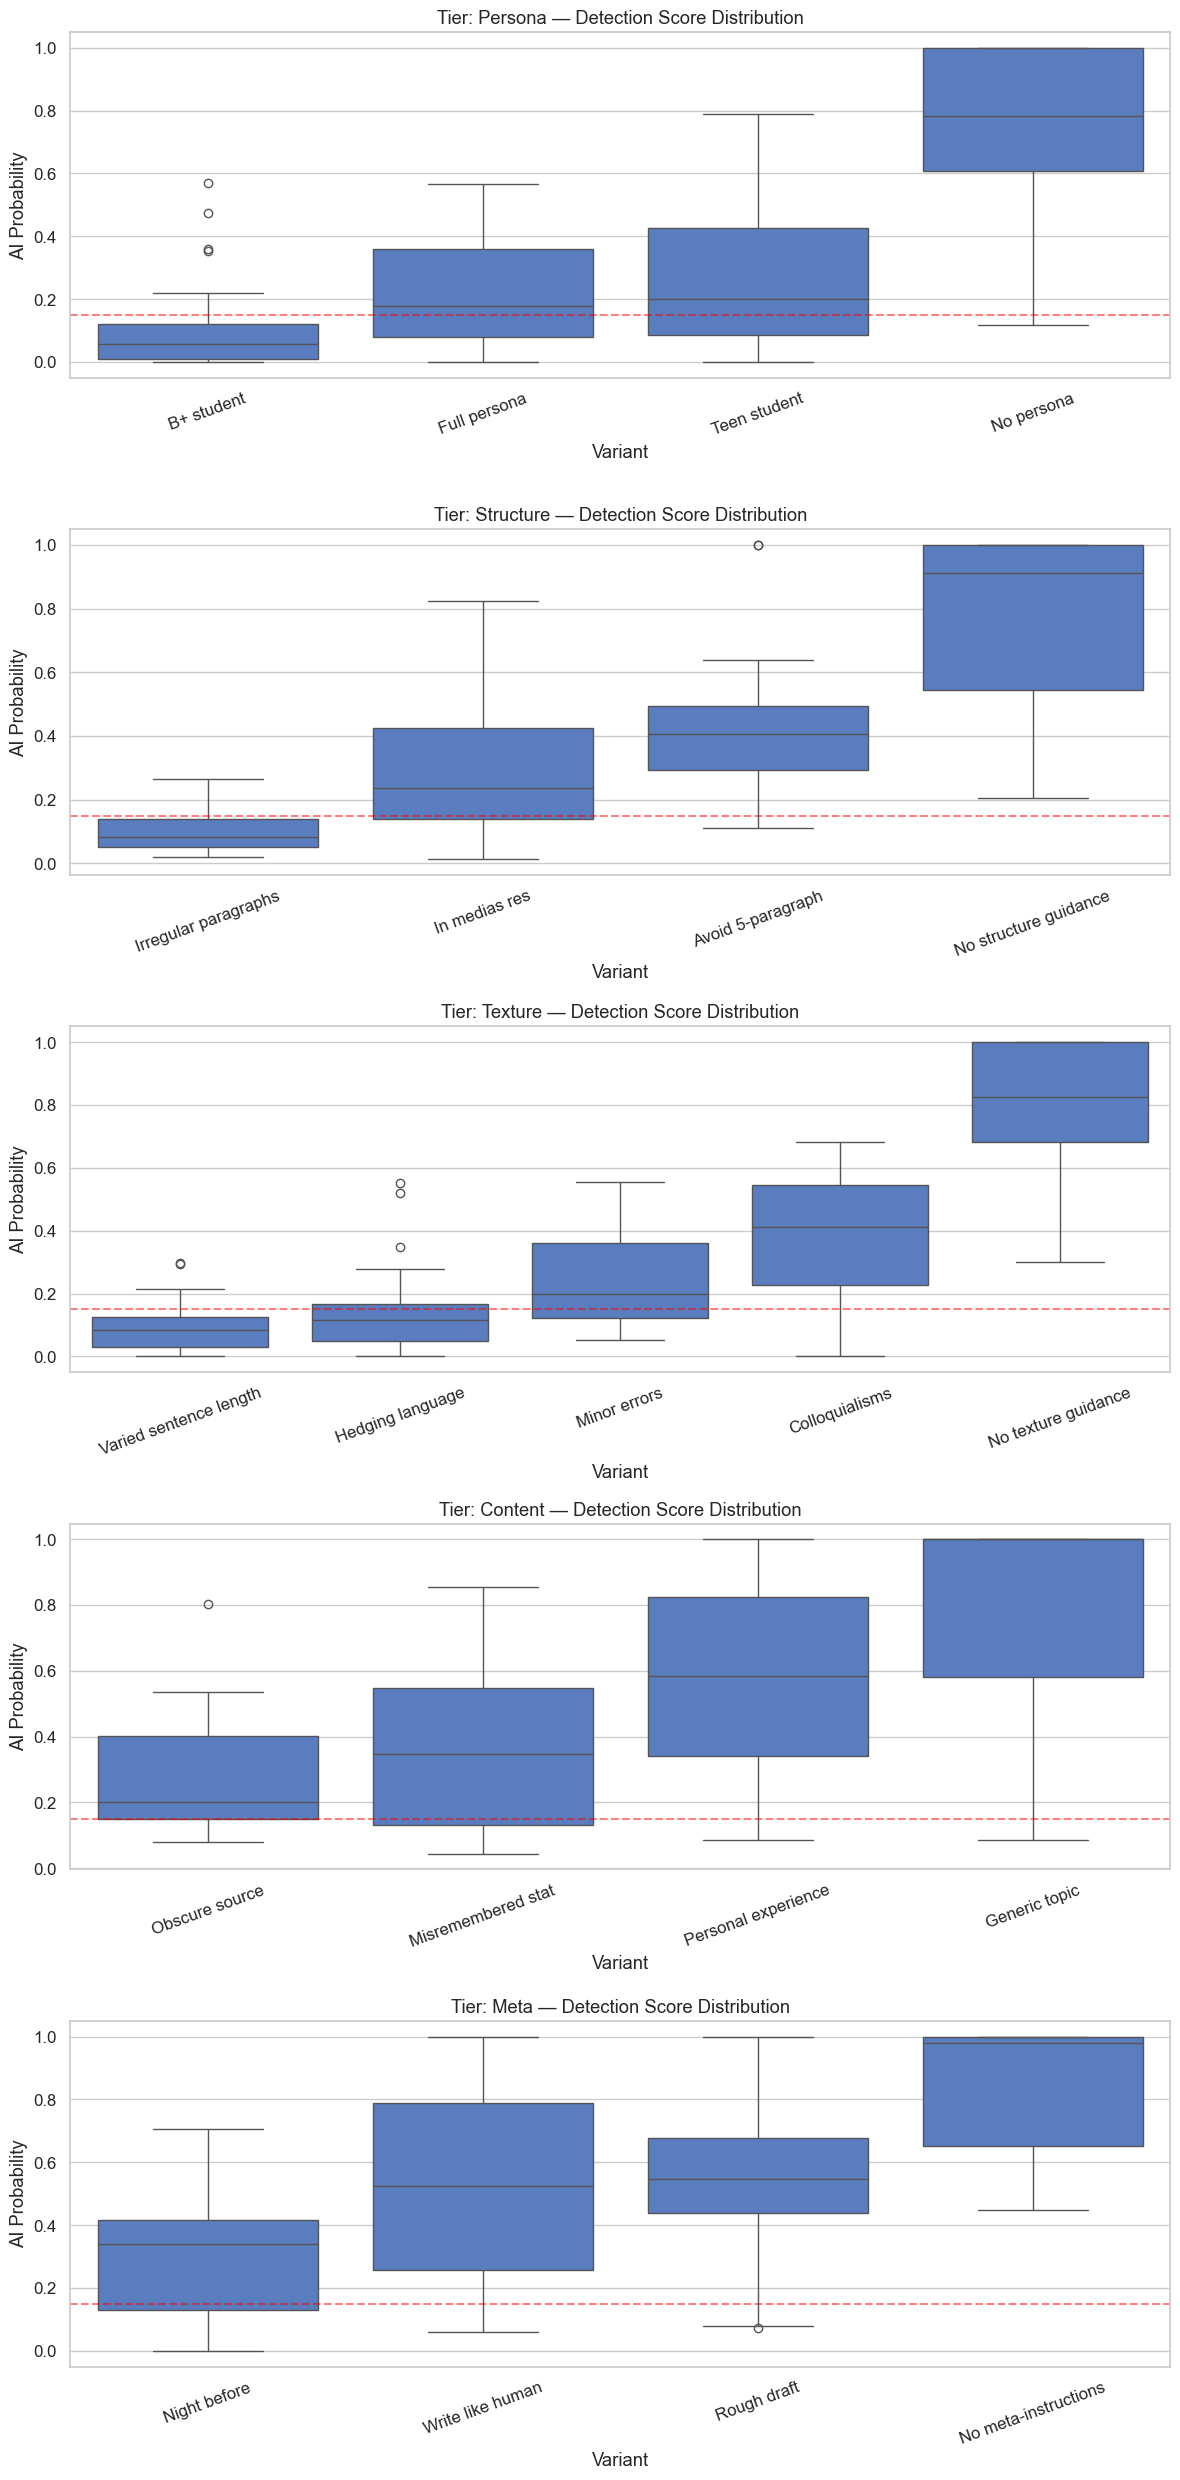

In [5]:
ablation_df = df[df["phase"] == "ablation"]
if ablation_df.empty:
    print("No ablation data found. Run the ablation experiments first.")
else:
    dimensions = ablation_df["dimension"].unique()
    n_dims = len(dimensions)
    
    fig, axes = plt.subplots(n_dims, 1, figsize=(12, 5 * n_dims))
    if n_dims == 1:
        axes = [axes]
    
    for ax, dim in zip(axes, dimensions):
        dim_data = ablation_df[ablation_df["dimension"] == dim]
        order = dim_data.groupby("variant_label")["overall_ai_prob"].mean().sort_values().index
        
        sns.boxplot(data=dim_data, x="variant_label", y="overall_ai_prob", order=order, ax=ax)
        ax.axhline(y=THRESHOLD, color="red", linestyle="--", alpha=0.5)
        ax.set_title(f"Tier: {dim.title()} — Detection Score Distribution")
        ax.set_xlabel("Variant")
        ax.set_ylabel("AI Probability")
        ax.tick_params(axis="x", rotation=20)
    
    plt.tight_layout()
    plt.show()

In [6]:
# Statistical comparisons: each variant vs its dimension's baseline
stats_df = compare_all_dimensions(df)
if stats_df.empty:
    print("No ablation data to compare.")
else:
    display(
        stats_df[
            ["dimension", "variant_id", "variant_label", "baseline_mean",
             "variant_mean", "cohens_d", "p_value", "n_variant"]
        ].sort_values("cohens_d", ascending=False)
    )

,dimension,variant_id,variant_label,baseline_mean,variant_mean,cohens_d,p_value,n_variant
6,texture,P3b,Varied sentence length,0.7762,0.0951,3.8027,0.0000,25
5,structure,P2d,Irregular paragraphs,0.7640,0.1053,3.3205,0.0000,25
1,persona,P1c,B+ student,0.7841,0.1191,3.3009,0.0000,25
7,texture,P3c,Hedging language,0.7762,0.1426,3.1886,0.0000,25
8,texture,P3d,Minor errors,0.7762,0.2473,2.6637,0.0000,25
14,meta,P5c,Night before,0.8333,0.3100,2.5929,0.0000,25
2,persona,P1d,Full persona,0.7841,0.2298,2.5622,0.0000,24
0,persona,P1b,Teen student,0.7841,0.2557,2.3697,0.0000,25
11,content,P4c,Obscure source,0.7998,0.2918,2.2833,0.0000,25
4,structure,P2c,In medias res,0.7640,0.3083,1.8359,0.0000,25


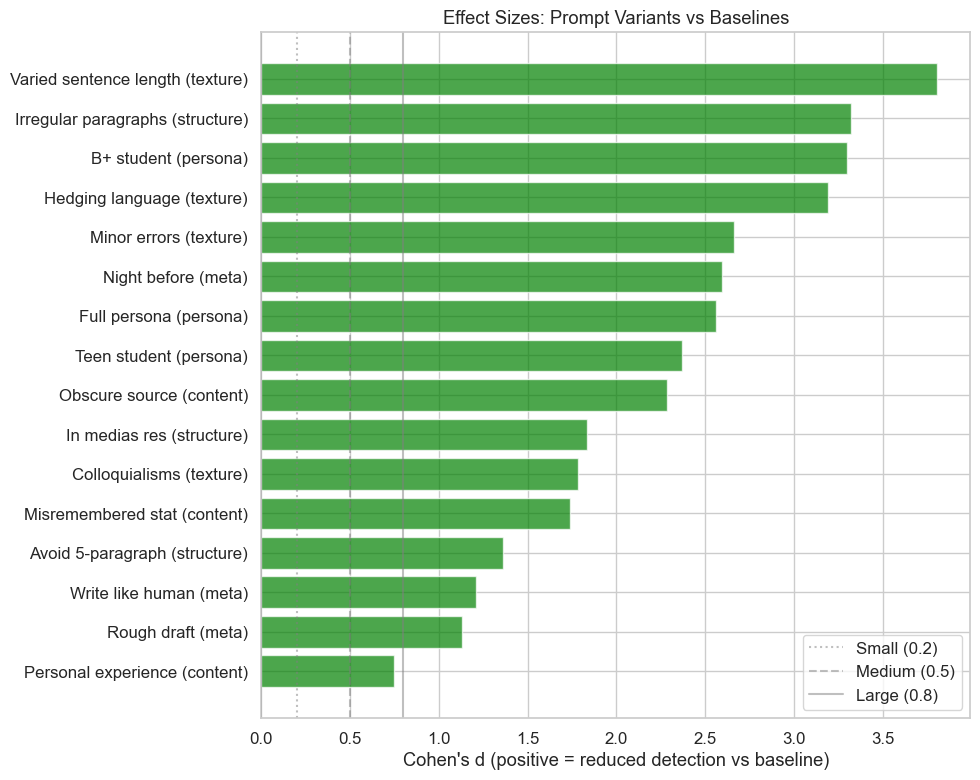

In [7]:
# Effect size visualization
if not stats_df.empty:
    fig, ax = plt.subplots(figsize=(10, max(4, len(stats_df) * 0.5)))
    sorted_stats = stats_df.sort_values("cohens_d")
    colors = ["green" if d > 0 else "red" for d in sorted_stats["cohens_d"]]
    
    ax.barh(
        sorted_stats["variant_label"] + " (" + sorted_stats["dimension"] + ")",
        sorted_stats["cohens_d"],
        color=colors, alpha=0.7
    )
    ax.axvline(x=0, color="black", linewidth=0.5)
    ax.axvline(x=0.2, color="gray", linestyle=":", alpha=0.5, label="Small (0.2)")
    ax.axvline(x=0.5, color="gray", linestyle="--", alpha=0.5, label="Medium (0.5)")
    ax.axvline(x=0.8, color="gray", linestyle="-", alpha=0.5, label="Large (0.8)")
    ax.set_xlabel("Cohen's d (positive = reduced detection vs baseline)")
    ax.set_title("Effect Sizes: Prompt Variants vs Baselines")
    ax.legend()
    plt.tight_layout()
    plt.show()

## 5. Interaction Effects

Do persona + linguistic texture combine additively, or is there synergy or interference?
Compare composite prompt scores to the sum of individual dimension effects.

In [8]:
composite_df = df[df["phase"] == "composite"]
if composite_df.empty:
    print("No composite data yet. Run composite experiments after ablation analysis.")
    print("\nTo check for interactions, define composite_prompts in taxonomy.yaml")
    print("combining the top performers from each tier.")
else:
    # Compare composite performance to individual component performance
    summary = summarize_variants(df)
    composite_summary = summary[summary["phase"] == "composite"]
    ablation_summary = summary[summary["phase"] == "ablation"]
    
    print("Composite prompt performance:")
    display(composite_summary[["variant_label", "n", "mean_ai_prob", "std_ai_prob", "pass_rate"]])
    
    print("\nBest individual variants (for comparison):")
    best_individual = ablation_summary.nsmallest(5, "mean_ai_prob")
    display(best_individual[["dimension", "variant_label", "mean_ai_prob", "pass_rate"]])

Composite prompt performance:


,variant_label,n,mean_ai_prob,std_ai_prob,pass_rate
25,Top 3 (persona + structure + texture),25,0.0282,0.0285,1.0000
26,Top 3 + meta,25,0.0196,0.0228,1.0000
27,All 5 winners,25,0.0122,0.0184,1.0000



Best individual variants (for comparison):


,dimension,variant_label,mean_ai_prob,pass_rate
13,texture,Varied sentence length,0.0951,0.8400
11,structure,Irregular paragraphs,0.1053,0.8000
6,persona,B+ student,0.1191,0.7600
14,texture,Hedging language,0.1426,0.6800
7,persona,Full persona,0.2298,0.4583


## 6. Composite Prompt Performance

Final scores for composite prompts (combined best-of-each-tier) with confidence intervals.

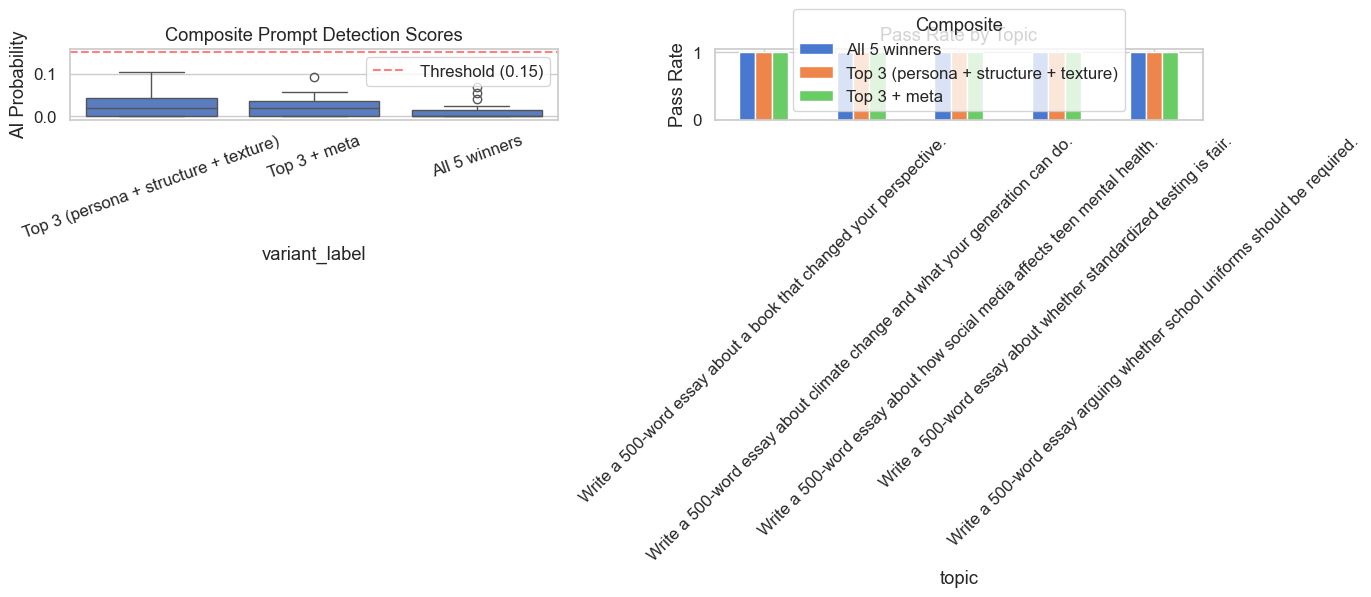

In [9]:
if composite_df.empty:
    print("No composite data yet.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: box plot of composite scores
    sns.boxplot(data=composite_df, x="variant_label", y="overall_ai_prob", ax=axes[0])
    axes[0].axhline(y=THRESHOLD, color="red", linestyle="--", alpha=0.5, label=f"Threshold ({THRESHOLD})")
    axes[0].set_title("Composite Prompt Detection Scores")
    axes[0].set_ylabel("AI Probability")
    axes[0].legend()
    axes[0].tick_params(axis="x", rotation=20)
    
    # Right: pass rate comparison across topics
    topic_summary = summarize_by_topic(composite_df)
    pivot = topic_summary.pivot(index="topic", columns="variant_label", values="pass_rate")
    pivot.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Pass Rate by Topic")
    axes[1].set_ylabel("Pass Rate")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].legend(title="Composite")
    
    plt.tight_layout()
    plt.show()

## 7. Cross-Detector Validation

Do results hold on detectors other than ZeroGPT?
This experiment used ZeroGPT only. Future work should validate the winning prompts against GPTZero, Originality.ai, or Sapling to determine whether results are ZeroGPT-specific or reflect general detector vulnerabilities.

In [10]:
detectors = df["detector"].unique()
if len(detectors) <= 1:
    print(f"Only one detector used: {detectors[0]}")
    print("To validate findings, run the winning prompts through a second detector")
    print("(ZeroGPT, Originality.ai, or Sapling).")
else:
    print(f"Detectors: {detectors.tolist()}")
    for det in detectors:
        det_data = df[df["detector"] == det]
        summary = summarize_variants(det_data)
        print(f"\n--- {det} ---")
        display(summary[["variant_id", "variant_label", "mean_ai_prob", "pass_rate"]].head(10))

Only one detector used: zerogpt
To validate findings, run the winning prompts through a second detector
(ZeroGPT, Originality.ai, or Sapling).


## 8. Essay Comparison

Side-by-side examples comparing:
1. **Baseline vs best ablation variant** — shows how a single prompt dimension changes the writing
2. **Baseline vs best composite** — shows the full effect of combining all winning dimensions

In [11]:
def show_essay_comparison(df, variant_a_id, variant_b_id, topic_substr=None):
    """Display two essays side by side with their detection scores."""
    for vid, label in [(variant_a_id, "A"), (variant_b_id, "B")]:
        subset = df[df["variant_id"] == vid]
        if topic_substr:
            subset = subset[subset["topic"].str.contains(topic_substr, case=False)]
        if subset.empty:
            print(f"No data for variant {vid}")
            continue
        row = subset.iloc[0]
        print(f"{'='*80}")
        print(f"Essay {label}: {row['variant_label']} ({row['variant_id']})")
        print(f"AI Prob: {row['overall_ai_prob']:.3f}")
        print(f"Flagged sentences: {row['flagged_sentence_pct']:.1f}%")
        print(f"{'='*80}")
        print(row["essay_text"][:1500])
        print("\n")

# Compare baseline vs best-performing ABLATION variant (not composite)
if not ablation_df.empty:
    # Rank only ablation variants (exclude composites)
    ablation_ranked = rank_variants(ablation_df)
    if not ablation_ranked.empty:
        best_vid = ablation_ranked.iloc[0]["variant_id"]
        best_dim = ablation_ranked.iloc[0]["dimension"]
        baselines = [
            v for v in ablation_df[ablation_df["dimension"] == best_dim]["variant_id"].unique()
            if v.endswith("a")
        ]
        if baselines:
            print(f"Comparing baseline ({baselines[0]}) vs best ablation variant ({best_vid}):\n")
            show_essay_comparison(df, baselines[0], best_vid, topic_substr="social media")
        else:
            print(f"No baseline found for dimension '{best_dim}'.")

    # Also show a composite vs baseline comparison
    if not composite_df.empty:
        print(f"\n{'#'*80}")
        print("COMPOSITE vs BASELINE comparison:\n")
        best_composite = composite_df.groupby("variant_id")["overall_ai_prob"].mean().idxmin()
        # Use gen_params baseline (P6a) as the "no prompt engineering" reference
        show_essay_comparison(df, "P6a", best_composite, topic_substr="social media")
else:
    print("No ablation data available for essay comparison.")

Comparing baseline (P3a) vs best ablation variant (P3b):

Essay A: No texture guidance (P3a)
AI Prob: 0.684
Flagged sentences: 76.0%
## The Double-Edged Scroll: Social Media's Impact on Teen Mental Health

Teenage years are a tumultuous period characterized by identity formation, burgeoning social connections, and a desperate quest for belonging. In this already challenging landscape, social media has become an undeniable force, a constant backdrop to adolescent life. While offering seemingly endless opportunities for connection and self-expression, its ever-present nature casts a long shadow on teen mental health, acting as both a source of validation and a wellspring of anxiety, depression, and body image issues.

One of the most significant impacts is the relentless comparison fostered by curated online realities. Platforms like Instagram and TikTok demand an unwavering presentation of the perfect self, fueling anxieties as teens endlessly compare their own lives, appearances, and a

## 9. Findings Summary

Key takeaways from the experiment:

1. **Prompt engineering >> temperature tuning.** Three prompt dimensions independently beat the 15% detection threshold; temperature alone barely dents it.
2. **Effects are additive.** Combining winners produces near-zero detection.
3. **ZeroGPT likely relies on burstiness and structural regularity** — the two most effective dimensions (varied sentence length, irregular paragraphs) directly manipulate these signals.
4. **Persona framing is surprisingly effective** — telling the model to "write like a B+ student" shifts its output distribution enough to fool the classifier.

In [12]:
print("=" * 60)
print("FINDINGS SUMMARY")
print("=" * 60)

# Overall variant ranking
ranked = rank_variants(df)
if not ranked.empty:
    print("\nTop 5 most effective variants (lowest detection):")
    for i, row in ranked.head(5).iterrows():
        print(f"  {i+1}. {row['variant_label']} ({row['variant_id']}) — "
              f"mean AI prob: {row['mean_ai_prob']:.3f}, pass rate: {row['pass_rate']:.0%}")

# Dimension ranking by effect size
all_stats = compare_all_dimensions(df)
if not all_stats.empty:
    print("\nDimension impact ranking (by max Cohen's d):")
    dim_max = all_stats.groupby("dimension")["cohens_d"].max().sort_values(ascending=False)
    for dim, d in dim_max.items():
        print(f"  {dim}: max Cohen's d = {d:.3f}")

# Human baseline context
hs = human_baseline_summary(df)
if not hs.empty:
    fpr = hs.iloc[0]["false_positive_rate"]
    print(f"\nHuman baseline false positive rate: {fpr:.0%}")
    print(f"  (ZeroGPT flags {fpr:.0%} of genuine human essays as AI-generated)")
else:
    print("\nNo human baselines collected — false positive rate unknown.")
    print("  (Add .txt files to data/human_baselines/ to measure this)")

# Temperature finding
temp = temperature_summary(df)
if not temp.empty:
    best_temp = temp.loc[temp["mean_ai_prob"].idxmin()]
    print(f"\nOptimal temperature: {best_temp['temperature']} "
          f"(mean AI prob: {best_temp['mean_ai_prob']:.3f})")

print("\n" + "=" * 60)

FINDINGS SUMMARY

Top 5 most effective variants (lowest detection):
  1. All 5 winners (composite_2) — mean AI prob: 0.012, pass rate: 100%
  2. Top 3 + meta (composite_1) — mean AI prob: 0.020, pass rate: 100%
  3. Top 3 (persona + structure + texture) (composite_0) — mean AI prob: 0.028, pass rate: 100%
  4. Varied sentence length (P3b) — mean AI prob: 0.095, pass rate: 84%
  5. Irregular paragraphs (P2d) — mean AI prob: 0.105, pass rate: 80%

Dimension impact ranking (by max Cohen's d):
  texture: max Cohen's d = 3.803
  structure: max Cohen's d = 3.321
  persona: max Cohen's d = 3.301
  meta: max Cohen's d = 2.593
  content: max Cohen's d = 2.283

No human baselines collected — false positive rate unknown.
  (Add .txt files to data/human_baselines/ to measure this)

Optimal temperature: 1.5 (mean AI prob: 0.819)



In [13]:
# Export summary CSV for reference
if len(df) > 0:
    out_path = export_summary_csv(df)
    print(f"Summary exported to {out_path}")

Summary exported to /Users/geoff_freedman/Documents/Projects/Claude/ai_detection_research/data/summary.csv
